# Эксперименты с XGBSE

## Чтение данных

In [18]:
import pandas as pd
from xgbse.converters import convert_to_structured
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split
from xgbse import (
    XGBSEDebiasedBCE,
    XGBSEKaplanNeighbors,
    XGBSEStackedWeibull,
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEBootstrapEstimator
    )
from xgbse.metrics import concordance_index, approx_brier_score, dist_calibration_score
import json
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter 

pd.set_option('display.max_rows', None)

In [19]:
accepted = pd.read_csv('lending_data/accepted_se_features.csv')
accepted.head().transpose()

,0,1,2,3,4
loan_amnt,3600.0,24700.0,10400.0,20000.0,20000.0
installment,123.03,820.28,289.91,637.58,631.26
sub_grade,14,11,26,7,6
emp_length,10,10,3,10,10
home_ownership,1,1,1,1,1
annual_inc,55000.0,65000.0,104433.0,180000.0,85000.0
verification_status,0,0,1,0,0
issue_d,42337,42337,42337,42337,42337
purpose,2,11,6,2,6
addr_state,38,41,38,23,40


## Выделение подвыборки для увеличения скорости обучения

In [20]:
accepted = accepted.sample(n=10000)

## Разделение выборки на тренировочную, валидационную и тестовую

In [21]:
X = accepted.drop(columns=['duration', 'event'])
y = convert_to_structured(accepted['duration'], accepted['event'])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2)

## Добавим трансформацию колонок для обучения модели

In [23]:
ohe_cols = ['home_ownership',
            'purpose',
            'initial_list_status',
            'disbursement_method',
            'has_been_last_delinq',
            'has_been_recent_revol_delinq',
            'has_been_last_major_derog',
            'has_been_recent_bc_dlq',
            'has_been_last_record',
            'verification_status',
            'addr_state']

numeric_cols = ['acc_now_delinq',
                'acc_open_past_24mths',
                'annual_inc',
                'avg_cur_bal',
                'bc_open_to_buy',
                'bc_util',
                'chargeoff_within_12_mths',
                'collections_12_mths_ex_med',
                'delinq_2yrs',
                'delinq_amnt',
                'dti',
                'earliest_cr_line',
                'emp_length',
                'fico_range_high',
                'fico_range_low',
                'inq_last_6mths',
                'installment',
                'issue_d',
                'last_credit_pull_d',
                'loan_amnt',
                'mo_sin_old_il_acct',
                 'mo_sin_old_rev_tl_op',
                 'mo_sin_rcnt_rev_tl_op',
                 'mo_sin_rcnt_tl',
                 'mort_acc',
                 'mths_since_recent_bc',
                 'mths_since_recent_inq',
                 'num_accts_ever_120_pd',
                 'num_actv_bc_tl',
                 'num_actv_rev_tl',
                 'num_bc_sats',
                 'num_bc_tl',
                 'num_il_tl',
                 'num_op_rev_tl',
                 'num_rev_accts',
                 'num_rev_tl_bal_gt_0',
                 'num_sats',
                 'num_tl_120dpd_2m',
                 'num_tl_30dpd',
                 'num_tl_90g_dpd_24m',
                 'num_tl_op_past_12m',
                 'open_acc',
                 'pct_tl_nvr_dlq',
                 'percent_bc_gt_75',
                 'pub_rec',
                 'pub_rec_bankruptcies',
                 'sub_grade',
                 'tax_liens',
                 'tot_coll_amt',
                 'tot_cur_bal',
                 'tot_hi_cred_lim',
                 'total_acc',
                 'total_bal_ex_mort',
                 'total_bc_limit',
                 'total_il_high_credit_limit',
                 'total_rev_hi_lim']

col_transformer = ColumnTransformer([('ohe_transformer', OneHotEncoder(handle_unknown='infrequent_if_exist'), ohe_cols),
                                    ('norm', Normalizer(), numeric_cols)],
                                   remainder='passthrough')

# X_train = col_transformer.fit_transform(X_train)
# X_val = col_transformer.transform(X_val)
# X_test = col_transformer.transform(X_test)

In [24]:
X_train.shape

(5600, 75)

In [25]:
xgbse_kaplan_model = XGBSEKaplanNeighbors()

xgbse_kaplan_model.fit(X_train, y_train, validation_data=(X_val, y_val), early_stopping_rounds=10)

XGBSEKaplanNeighbors(xgb_params={'aft_loss_distribution': 'normal',
                                 'aft_loss_distribution_scale': 1,
                                 'booster': 'dart', 'colsample_bynode': 0.5,
                                 'eval_metric': 'aft-nloglik',
                                 'learning_rate': 0.05, 'max_depth': 8,
                                 'min_child_weight': 50,
                                 'objective': 'survival:aft', 'subsample': 0.5,
                                 'tree_method': 'hist'})

## Обучим различные модели и посмотрим на их метрики

In [26]:
with open('./tmp/base_data.json', 'r') as file:
    base_data = json.load(file)

In [27]:
TIME_BINS = np.arange(min(base_data['x']), max(base_data['x']), 25)

In [28]:
def run_pipeline(model):
    print(f'training {model.__class__.__name__}.....')
    model.fit(X_train, y_train, validation_data=(X_val, y_val), early_stopping_rounds=10, time_bins=TIME_BINS)
    print('predicting....')
    preds = model.predict(X_test)
    print('Counting C-Index')
    cind = concordance_index(y_test, preds)
    brier = approx_brier_score(y_test, preds)
    dist = dist_calibration_score(y_test, preds, returns='all')
    return cind, brier, dist

In [29]:
models = [
          XGBSEDebiasedBCE(),
          XGBSEKaplanNeighbors(),
          XGBSEStackedWeibull(),
        ]
metrics = dict()

for model in models:
    metrics[model.__class__.__name__] = run_pipeline(model)

    print(f'Model {model.__class__.__name__} C-Index: {metrics[model.__class__.__name__][0]}')

training XGBSEDebiasedBCE.....


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


predicting....
Counting C-Index
Model XGBSEDebiasedBCE C-Index: 0.7355284540517043
training XGBSEKaplanNeighbors.....
predicting....
Counting C-Index
Model XGBSEKaplanNeighbors C-Index: 0.7388961339287745
training XGBSEStackedWeibull.....
predicting....
Counting C-Index
Model XGBSEStackedWeibull C-Index: 0.7481149206541765


In [30]:
for col in metrics:
    print(col)
    print(metrics[col][0], metrics[col][1])

XGBSEDebiasedBCE
0.7355284540517043 inf
XGBSEKaplanNeighbors
0.7388961339287745 inf
XGBSEStackedWeibull
0.7481149206541765 inf


## Отрисуем кривые дожития

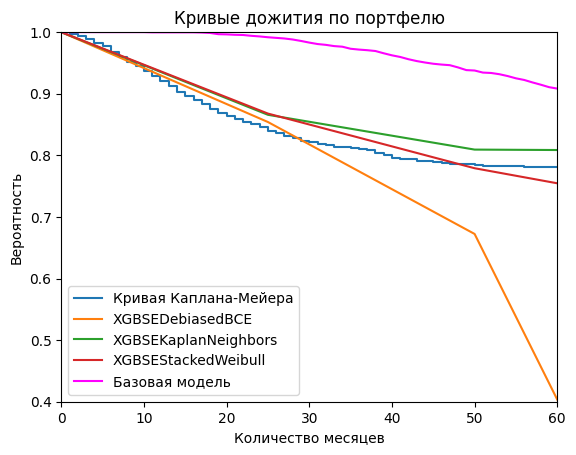

In [40]:
kmf = KaplanMeierFitter(label="Кривая Каплана-Мейера")
kmf.fit(accepted['duration'], accepted['event'])
kmf.plot(ci_show=False)

for model in models:
    preds = model.predict(X_test)
    # vals = [np.count_nonzero(preds < i) for i in base_data['x']]
    # vals = [i / len(preds) for i in vals]
    
    plt.plot(preds.columns, preds.mean(), label=model.__class__.__name__)
    
plt.plot(base_data['x'], base_data['y'], label="Базовая модель", c='fuchsia')
plt.title("Кривые дожития по портфелю")
plt.xlabel('Количество месяцев')
plt.ylabel('Вероятность')
plt.xlim((0, 60))
plt.ylim((0.4, 1))
plt.legend()